In [2]:
#https://medium.com/techbloghotmart/o-que-s%C3%A3o-s%C3%A9ries-temporais-e-como-aplicar-em-machine-learning-6ea5d94bec78
#https://machinelearningmastery.com/time-series-data-stationary-python/
#https://github.com/je-suis-tm/quant-trading
#https://github.com/lukstei/trading-backtest
#https://github.com/dv-lebedev/pair-trading-view
# half-life
#https://medium.com/@constandinou.antonio/quant-post-3-1-a-guided-path-into-mean-reversion-8b33b3c279e4

import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import statistics
import matplotlib.pyplot as plt

In [5]:
# http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/

#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        self.testStatistic = None
        self.beta = None
        
    def CheckStationarity(self, y, x, printResults = False):
        model = model_ols(y, x)

        #Dickey-Fuller test:
        adfTest = ts.adfuller(model.resid)
        
        self.pValue = adfTest[1]
        self.testStatistic = adfTest[0:1][0]
        self.beta = model.params[1]
        
        if (self.pValue < self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            print('Augmented Dickey-Fuller Test Results:')
            print('ADF Test Statistic    ', adfTest[0:1][0])
            print('P-Value               ', adfTest[1:2][0])
            print('# Lags Used           ', adfTest[2:3][0])
            print('# Observations Used   ', adfTest[3:4][0])
            
            dfResults = pd.Series()
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print(dfResults)
            
            print("Is the time series stationary? {0}".format(self.isStationary))

def model_ols(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model

def hedge_ratio(Y, X):
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    return model.params[1]

def beta(y, x):
    model = model_ols(y, x)
    return model.params[1]

def namefile(file):
    return os.path.splitext(file)[0]

def checkStationarity(y, x, printResults = True):
    check = StationarityTests()
    return check.CheckStationarity(y, x , printResults = printResults)
    
# check cointegrated pairs from dataframe
def find_cointegrated_pairs(data, num_pairs=0, noStationary=False):
    test = StationarityTests()
    rows = []
    isBreak = False
        
    for col_depen in data.columns:
        for col_indepen in data.columns:
            if (col_depen == col_indepen):
                continue

            test.CheckStationarity(data[col_depen], data[col_indepen])
            # if get only not stationary
            if (noStationary):
                if(test.isStationary==False):
                    rows.append([col_depen,col_indepen,test.pValue, test.testStatistic, test.beta])
            elif (test.isStationary):
                    rows.append([col_depen,col_indepen,test.pValue, test.testStatistic, test.beta])
                    
            # break for two
            isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
            if (isBreak == True): break
        
        # break for one
        if (isBreak == True): break
            
    df_pairs = pd.DataFrame(rows, columns=['Depen', 'Indepen', 'pValue', 'ADFTestStatistic', 'Beta'])
    return df_pairs

# check cointegrated pairs from directory of csv's
def find_cointegrated_pairs_foldercsv(path, num_pairs=0, noStationary=False):
    test = StationarityTests()
    rows = []
    isBreak = False
    
    # for each all files csv in directory 'datasets', read
    for fdepen in os.listdir(path):
        # read the first csv
        y_depen = pd.read_csv(path + '/'+fdepen)['Fechamento']
        
        for findepen in os.listdir(path):
            csv_name1 = namefile(fdepen)
            csv_name2 = namefile(findepen)

            # continue if it is the same csv
            if(csv_name1 == csv_name2):
                continue

            # read then second csv
            x_indepen = pd.read_csv(path+'/'+findepen)['Fechamento']
            test.CheckStationarity(y_depen, x_indepen)
            
            # if get only not stationary
            if (noStationary):
                if(test.isStationary==False):
                    rows.append([csv_name1,csv_name2,test.pValue, test.testStatistic, test.beta])
            elif (test.isStationary):
                    rows.append([csv_name1,csv_name2,test.pValue, test.testStatistic, test.beta])
            
            # break for two
            isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
            if (isBreak == True): break
        
        # break for one
        if (isBreak == True): break
            
    df_pairs = pd.DataFrame(rows, columns=['Depen', 'Indepen', 'pValue', 'ADFTestStatistic', 'Beta'])
    return df_pairs

def signal(y, x):
    model = model_ols(y, x)
    std = statistics.stdev(model.resid)
    resi_curr = model.resid.iloc[-1]
    zscore_up = 2*std
    zscore_down = -2*std
    zcurrent = 0
    desc = ''
    
    # >0; resíduo acima da linha 0
    if(resi_curr > 0):
        desc = 'Acima'
        zcurrent = zscore_up
    else:
        desc = 'Abaixo'
        zcurrent = zscore_down
    
    percent = (abs(resi_curr)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return [desc, resi_curr, percent]

def find_pairs_oper(pairs, data, perc_dist=0.9, num_pairs=0):
    rows = []
    isBreak = False
    
    for i, j in pairs.iterrows():
        sinal = signal(data[j['Depen']], data[j['Indepen']])
        perc = sinal[2]

        # % de distância da linha 0
        if(perc >= perc_dist):
            rows.append([j['Depen'], j['Indepen'], perc])
            
        # break for two
        isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
        if (isBreak == True): break
                
    df_operations = pd.DataFrame(rows, columns=['Depen', 'Indepen', 'PercDist'])
    return df_operations

def graphicShow(data, y_name, x_name):
    y = data[y_name]
    x = data[x_name]
    
    model=model_ols(y, x)
    std = statistics.stdev(model.resid)
    entry_threshold = 2 # entrada em 2 desvio padrão

    #plt.figure(figsize=(15,6))
    plt.figure(figsize=(10,5))
    plt.plot(model.resid)
    plt.ylabel('Residual')
    plt.title(y_name + ' / ' + x_name)

    plt.axhline(0, linewidth=1,color='black',label='mean') # Add the mean of residual
    plt.axhline(entry_threshold*std, color='green', linestyle='--',label='trade')
    plt.axhline(-entry_threshold*std, color='green', linestyle='--')

    plt.legend()
    plt.show()

### Test with csv

In [7]:
y = pd.read_csv('datasets-b3/AALR3.csv')['Fechamento']
x = pd.read_csv('datasets-b3/ALSO3.csv')['Fechamento']

"""y = data['AALR3']
x = data['ABCB4']"""

par = StationarityTests()
par.CheckStationarity(y, x, printResults = True)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -3.6373142127726843
P-Value                0.005086448368083348
# Lags Used            0
# Observations Used    91
Critical Value (1%)    -3.504343
Critical Value (5%)    -2.893866
Critical Value (10%)   -2.584015
dtype: float64
Is the time series stationary? True


### Read CSV

In [3]:
df = pd.read_csv('datasets/data.csv')
data = df[df.columns.difference(['Data'])]

## Single test

In [48]:
checkStationarity(data['ABCB4'], data['AZUL4'], printResults = True)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -3.2141908124356218
P-Value                0.01917781427486066
# Lags Used            0
# Observations Used    91
Critical Value (1%)    -3.504343
Critical Value (5%)    -2.893866
Critical Value (10%)   -2.584015
dtype: float64
Is the time series stationary? True


### Pairs Cointegrated

In [49]:
pairs = find_cointegrated_pairs(data, num_pairs=5)
pairs
#pairs.to_csv('datasets/cointegrated_pairs.csv')

,Depen,Indepen,pValue,ADFTestStatistic,Beta
0,AALR3,ABCB4,0.023039,-3.150434,1.308303
1,AALR3,ALSO3,0.005086,-3.637314,0.424785
2,AALR3,ALUP11,0.012425,-3.359362,1.681917
3,AALR3,ALUP4,0.021314,-3.177666,4.338075
4,AALR3,AMAR3,0.040183,-2.946679,1.286800


### Some example of graphic

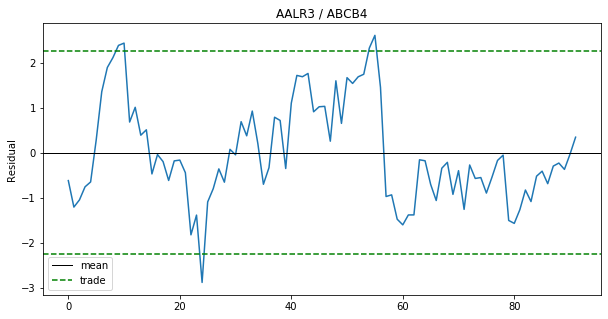

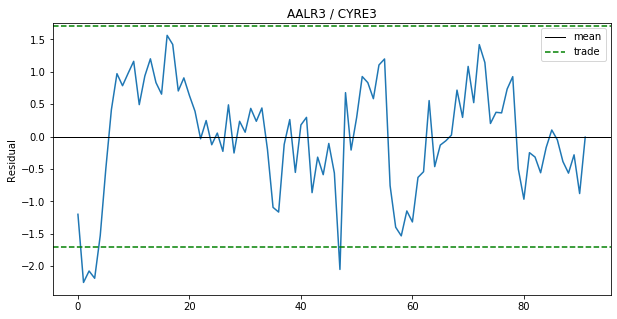

In [29]:
graphicShow(data, 'AALR3', 'ABCB4')
graphicShow(data, 'AALR3', 'CYRE3')

### Graphic Cointegrated all Pairs

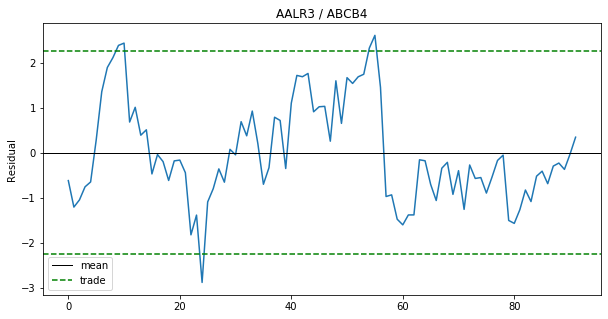

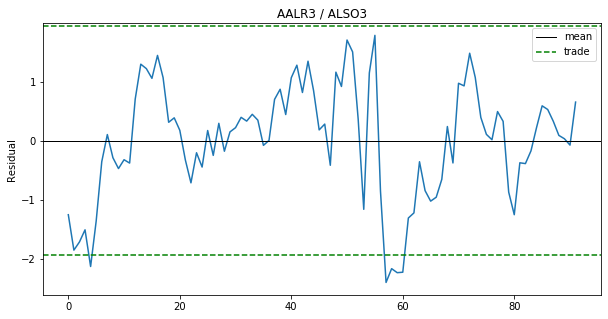

In [33]:
quantOnly = 2 # quantidade de gráficos exibir
for i, j in pairs.iterrows():
    graphicShow(data, j['Depen'], j['Indepen'])
    
    # somente alguns
    if((i+1) >= quantOnly):
        break

# Trades

### Signal trade, example

In [31]:
print(signal(data['AALR3'], data['ABCB4']))
print(signal(data['AALR3'], data['CYRE3']))

['Acima', 0.34231410174760946, 0.15203095984903695]
['Abaixo', -0.00855415040673968, 0.005006850267471835]


### Find pairs to operator

In [42]:
#pairs = pd.read_csv('datasets/cointegrated_pairs.csv')

df_operations = find_pairs_oper(pairs, data, perc_dist=0.95, num_pairs=5)
print(str(df_operations.shape[0])+' pares sinalizando entrada')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


5 pares sinalizando entrada


In [43]:
df_operations

,Depen,Indepen,PercDist
0,ABEV3,BRAP3,1.055830
1,ALPA3,BRAP3,1.097675
2,ALPA4,ALUP11,0.970341
3,ALPA4,ALUP4,0.987265
4,ALPA4,BOVA11,1.155789


In [18]:
oper_quantOnly = 5 # quantidade de gráficos exibir
for i, j in df_operations.iterrows():
    graphicShow(data, j['Depen'], j['Indepen'])
    
    # somente alguns
    if((i+1) >= oper_quantOnly):
        break

# Non-stationary pairs, examples

In [19]:
nopairs = find_cointegrated_pairs(data, 2, noStationary=True)
nopairs

,Depen,Indepen,pValue,ADFTestStatistic
0,AALR3,AAPL34,0.737010,-1.043658
1,AALR3,ABEV3,0.127624,-2.451886


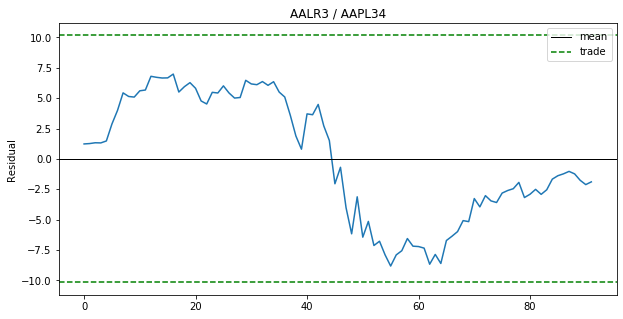

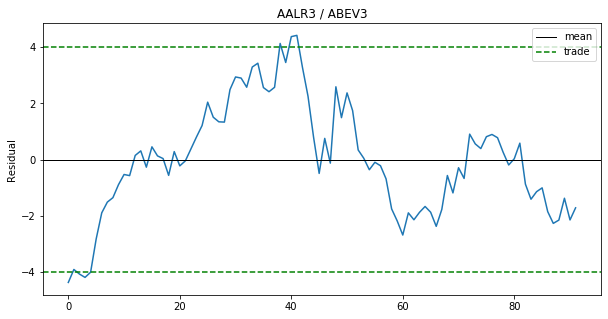

In [20]:
graphicShow(data, 'AALR3', 'AAPL34')
graphicShow(data, 'AALR3', 'ABEV3')